### DoRothEA VS CollecTRI

&emsp;&emsp;&emsp;



<br></br>

### **Data Preparation**

In [ ]:
# Install necessary libraries
%pip install scanpy
%pip install decoupler
%pip install pydeseq2
%pip install adjustText
%pip install omnipath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=d51879f0ea795a040844b9d579f89a58adf17912dca30dc7658e727c90aba9b7
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=951a3e9625075b4a007b34add8051acaca8c9f392809b063e7d2fb745420601a
  Stored in directory: /root/.cache/pip/wheels/6a/aa/

In [ ]:
# Import Necessary libraries
import scanpy as sc
import decoupler as dc
import omnipath as op

# Data Manipulation
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy import stats

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Differential Expression Analysis (DESeq2)
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import warnings
warnings.filterwarnings("ignore")

import os
os.mkdir("/content/datasets")

In [ ]:
# Retrieve CollecTRI gene regulatory network
try:
    collectri = dc.get_collectri(organism='human', split_complexes=False)
    collectri.to_csv("datasets/collectri.csv",index=False)
except:
    collectri = pd.read_table("datasets/collectri.csv", sep=',')
collectri

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [ ]:
# Retrieve DoRothEA gene regulatory network
try:
    dorothea = dc.get_dorothea(organism='human')
    dorothea.to_csv("datasets/dorothea.csv",index=False)
except:
    dorothea = pd.read_table("datasets/dorothea.csv", sep=',')
dorothea

0.00B [00:00, ?B/s]

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


In [ ]:
# Download the data from GEO
try:
    !wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
    !gzip -d -f counts.txt.gz
    !mv counts.txt datasets/counts.txt
except:
    print("Error! Please upload counts.txt file manually.")

# Read raw data and process it
adata_table = pd.read_csv('datasets/counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata_table

--2023-09-22 01:24:35--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1.5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1.50M  --.-KB/s    in 0.1s    

2023-09-22 01:24:35 (14.9 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]



GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


In [ ]:
# Transform to AnnData object
adata = AnnData(adata_table, dtype=np.float32)
adata.var_names_make_unique()

# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    layers: 'counts', 'cpm'

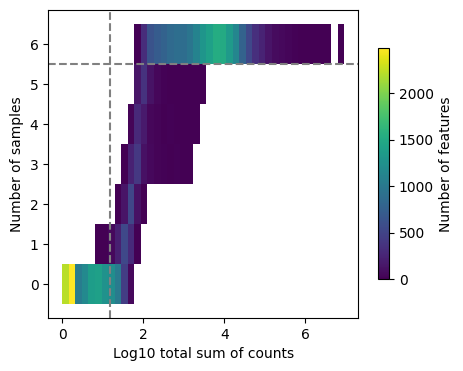

In [ ]:
# Quality Control (optional but recommended)
# --- only the genes in the upper-right corner are going to be kept
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata_filtered = adata[:, genes].copy()

# Normalize total-count per million, CPM (library-size correct)
sc.pp.normalize_total(adata_filtered, target_sum=1e6)

# Store normalized counts in layers
adata_filtered.layers['cpm'] = adata_filtered.X

# Visualize adata
adata_filtered

In [ ]:
# Convert anndata to dataframe
mat = adata_filtered.to_df(layer='cpm')
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0.861613,0.600518,2.637059,1.305475,1.853774,0.496080,20.391516,51.644581,12.323682,628.011658,...,2433.196045,8.929447,12.428120,12.871981,1422.079712,448.665558,33.994560,1412.497559,6.736249,12.402010
26_HSCs-Ctrl2,1.341323,0.914539,2.581031,0.751954,0.975508,0.934862,18.026571,48.328281,9.734755,522.831543,...,2335.406250,7.214693,7.885355,8.860863,1314.862549,428.938904,30.322033,1273.830200,5.141739,8.047939
27_HSCs-Ctrl3,0.969110,0.633649,2.012767,0.838653,1.062294,0.465918,20.779961,56.823406,10.138384,572.576416,...,2895.496338,7.026049,8.162890,8.945633,1596.236328,593.766357,37.888481,1669.087402,5.255559,8.349257
31_HSCs-TGFb1,0.965408,0.536338,2.592299,0.500582,1.841426,0.536338,15.375017,44.802082,7.937799,367.212616,...,1982.054199,6.668467,7.884166,8.599282,1078.485962,348.548065,25.869360,1185.002563,3.075003,6.096373
32_HSCs-TGFb2,1.027534,0.653885,1.821537,0.607179,1.447888,0.607179,9.457981,26.295525,7.146030,227.505325,...,1062.283081,5.581377,7.729856,8.010093,640.854126,211.438431,14.572297,643.026001,2.241892,5.044257
33_HSCs-TGFb3,0.796692,0.522829,2.190902,0.423242,1.468900,0.248966,15.037556,47.253777,7.070639,369.415955,...,1760.290283,8.564435,11.278167,12.373617,1131.376831,343.473694,26.813654,1080.886475,4.780150,6.049877


In [ ]:
mat.apply([np.sum, np.min, np.max], axis=1)

,sum,amin,amax
25_HSCs-Ctrl1,1.000000e+06,0.234985,16724.437500
26_HSCs-Ctrl2,1.000000e+06,0.223554,20666.802734
27_HSCs-Ctrl3,1.000000e+06,0.223641,21531.746094
31_HSCs-TGFb1,1.000000e+06,0.232413,53465.296875
32_HSCs-TGFb2,1.000000e+06,0.233530,55140.593750
33_HSCs-TGFb3,1.000000e+06,0.224070,59497.929688


### **TASK 1** Without DEA

#### Calculate the TF activity

In [ ]:
# Infer TF activities with ulm using CollecTRI network
tf_collectri_acts, tf_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_collectri_acts
# tf_collectri_acts.apply([np.sum, np.min, np.max], axis=1)
# tf_collectri_acts.shape

Running ulm on mat with 6 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
25_HSCs-Ctrl1,1.065369,3.513768,-0.092619,9.416823,3.750810,7.374182,2.209627,0.792456,-0.073562,-0.119644,...,2.369821,1.127670,-0.358643,17.152018,-0.152018,0.223835,0.792804,-0.641132,-0.200024,1.450069
26_HSCs-Ctrl2,1.030500,3.439764,-0.108949,9.543247,3.511437,7.277483,2.080467,0.805713,-0.070083,-0.108495,...,2.047254,1.055401,-0.310071,19.226736,-0.127963,0.200891,0.684690,-0.659765,-0.191540,1.307216
27_HSCs-Ctrl3,1.062467,3.423932,-0.105873,9.529863,3.719286,7.011393,2.019213,0.803646,-0.044515,-0.098158,...,2.195279,1.095722,-0.281857,19.752375,-0.130376,0.231477,0.739110,-0.655897,-0.193930,1.433861
31_HSCs-TGFb1,0.341344,2.637449,-0.137243,9.362064,1.862120,8.492096,0.501636,0.297469,-0.033156,-0.101031,...,0.258564,0.462094,-0.082978,16.974936,-0.076635,0.083366,0.223191,-0.273286,-0.090176,0.539266
32_HSCs-TGFb2,0.341261,2.539009,-0.125790,9.223310,1.679006,8.553974,0.518021,0.306204,-0.041595,-0.098013,...,0.221584,0.438338,-0.116582,16.314453,-0.093113,0.047600,0.247142,-0.285474,-0.080971,0.547607
33_HSCs-TGFb3,0.310873,2.437673,-0.130148,9.481165,1.448070,8.715354,0.467010,0.262756,-0.043612,-0.103782,...,0.259061,0.411983,-0.123147,14.641565,-0.087410,0.042556,0.246827,-0.249543,-0.083871,0.495250


In [ ]:
# Infer TF activities with ulm using DoRothEA network
tf_dorothea_acts, tf_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea, verbose=True)
tf_dorothea_acts
# tf_dorothea_acts.apply([np.sum, np.min, np.max], axis=1)
# tf_dorothea_acts.shape

Running ulm on mat with 6 samples and 17575 targets for 281 sources.


,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
25_HSCs-Ctrl1,1.021086,3.672184,0.669489,0.081744,2.697176,0.406037,1.640476,9.651978,0.612117,1.249952,...,1.153679,-0.362536,2.313812,-0.243042,1.458922,0.229469,0.236344,0.888968,-0.119325,0.818214
26_HSCs-Ctrl2,0.837120,3.125765,0.522897,0.059671,2.484155,0.425281,1.518833,11.370803,0.600986,1.228788,...,1.089787,-0.348231,2.313849,-0.225304,1.381332,0.223435,0.209429,0.743977,-0.103536,0.821655
27_HSCs-Ctrl3,0.733425,3.235074,0.362701,0.039755,2.302288,0.379323,1.453785,9.988415,0.632513,1.174859,...,0.941741,-0.352394,2.391270,-0.243336,1.257836,0.177968,0.197425,0.655634,-0.124677,0.821915
31_HSCs-TGFb1,0.146720,1.907997,0.176476,0.030676,1.489435,0.167627,0.882310,24.084148,0.323295,0.646517,...,0.294664,-0.155068,0.951346,-0.236343,0.557975,0.017112,0.024222,0.267927,-0.058889,0.247535
32_HSCs-TGFb2,0.142365,1.933520,0.198579,0.066514,1.523887,0.155074,0.908797,24.430395,0.302602,0.680592,...,0.323096,-0.145248,0.818233,-0.234875,0.546379,0.014626,0.004064,0.317364,-0.036936,0.213982
33_HSCs-TGFb3,0.148002,1.912735,0.190550,0.049040,1.451231,0.150502,0.834315,25.430475,0.284248,0.620383,...,0.334270,-0.142322,0.814429,-0.233602,0.530376,0.006014,-0.006023,0.318174,-0.029797,0.211474


In [ ]:
# Filter p-value < 0.05 in collectri TF activity
tf_collectri_acts_filtered = tf_collectri_acts.loc[:, tf_collectri_pvals.lt(0.05).all()]
tf_collectri_acts_filtered.shape

(6, 173)

In [ ]:
# Filter p-value < 0.05 in dorothea TF activity
tf_dorothea_acts_filtered = tf_dorothea_acts.loc[:, tf_dorothea_pvals.lt(0.05).all()]
tf_dorothea_acts_filtered.shape

(6, 57)

#### Classify the Overlap TF into groups (by significant)

In [ ]:
significant_tf_collectri = tf_collectri_pvals.columns[(tf_collectri_pvals < 0.05).all()]
significant_tf_dorothea = tf_dorothea_pvals.columns[(tf_dorothea_pvals < 0.05).all()]

# Find the overlapping TFs between collectri and dorothea
overlap_tfs = set(tf_collectri_acts.columns) & set(tf_dorothea_acts.columns)

# Classify into 4 groups
acts_collectri = overlap_tfs & set(significant_tf_collectri) - set(significant_tf_dorothea)
acts_dorothea = overlap_tfs & set(significant_tf_dorothea) - set(significant_tf_collectri)
acts_both = overlap_tfs & set(significant_tf_collectri) & set(significant_tf_dorothea)
acts_none = overlap_tfs - acts_collectri - acts_dorothea - acts_both

# Convert set objects to lists
acts_collectri = list(acts_collectri)
acts_dorothea = list(acts_dorothea)
acts_both = list(acts_both)
acts_none = list(acts_none)

# Print the result
print(f"acts_collectri: {len(acts_collectri):d}")
print(f"acts_dorothea: {len(acts_dorothea):d}")
print(f"acts_both: {len(acts_both):d}")
print(f"acts_none: {len(acts_none):d}")
print(f"acts_sum: {len(acts_collectri)+len(acts_dorothea)+len(acts_both)+len(acts_none):d}")

acts_collectri: 46
acts_dorothea: 22
acts_both: 33
acts_none: 140
acts_sum: 241


In [ ]:
mean_acts_collectri = tf_collectri_acts[acts_collectri].mean(axis=0)
mean_acts_dorothea = tf_collectri_acts[acts_dorothea].mean(axis=0)
mean_acts_both = (tf_collectri_acts[acts_both] + tf_dorothea_acts[acts_both]) / 2
mean_acts_none = (tf_collectri_acts[acts_none] + tf_dorothea_acts[acts_none]) / 2

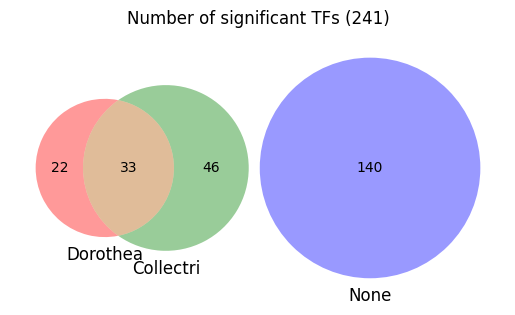

In [ ]:
from matplotlib_venn import venn3

venn = venn3(subsets={
    '100': len(acts_dorothea),  # Only Dorothea
    '010': len(acts_collectri),  # Only Collectri
    '110': len(acts_both),  # Significant in both
    '001': len(acts_none)  # Not significant in either
}, set_labels=('Dorothea', 'Collectri', 'None'))
plt.title('Number of significant TFs (241)')
plt.show()

#### Customs Function

In [ ]:
#@title ##### Function: Calculate the mean correlation of regulons

def calculate_correlation_regulons(tf_lists, name_of_group):
    # tf_lists = matched_columns_filtered.to_list()
    # name_of_group = "collectri"

    # Placeholder for means & Jaccard Index values
    means = []
    weights = []
    jaccard_indices = []
    jaccard_indices_weight = []
    jaccard_regulons = []

    # Loop through each TF in tf_lists:
    for tf in tf_lists:
        # Filtering to get the target column
        regulons_collectri = collectri.loc[collectri['source'] == tf, ['target','weight']]
        regulons_dorothea = dorothea.loc[dorothea['source'] == tf, ['target','weight']]

        # Filtering the 'mat' DataFrame
        df_mat_collectri = mat[regulons_collectri[regulons_collectri.target.isin(mat.columns)].target.to_list()]
        df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.target.isin(mat.columns)].target.to_list()]

        # Convert the weight values
        weights_sign_collectri = regulons_collectri.set_index('target').weight.apply(np.sign).to_dict()
        weights_sign_dorothea = regulons_dorothea.set_index('target').weight.apply(np.sign).to_dict()

        # Multiply the matrices by the sign of weight values
        df_mat_collectri_multiplied = df_mat_collectri.copy()
        df_mat_dorothea_multiplied = df_mat_dorothea.copy()
        for col in df_mat_collectri_multiplied.columns:
            df_mat_collectri_multiplied[col] *= weights_sign_collectri.get(col, 1)

        for col in df_mat_dorothea_multiplied.columns:
            df_mat_dorothea_multiplied[col] *= weights_sign_dorothea.get(col, 1)

        # Compute the Pearson correlation
        correlation_collectri = df_mat_collectri_multiplied.corr()
        correlation_dorothea = df_mat_dorothea_multiplied.corr()

        # Sort the correlation matrices by the average correlation value
        sorted_columns_collectri = correlation_collectri.mean().sort_values(ascending=False).index
        sorted_columns_dorothea = correlation_dorothea.mean().sort_values(ascending=False).index

        correlation_collectri = correlation_collectri.loc[sorted_columns_collectri, sorted_columns_collectri]
        correlation_dorothea = correlation_dorothea.loc[sorted_columns_dorothea, sorted_columns_dorothea]

        # Calculate the mean correlation
        # Extract upper triangle of the matrix (excluding the diagonal)
        upper_triangle_collectri = correlation_collectri.where(np.triu(np.ones(correlation_collectri.shape), k=1).astype(bool))
        # Compute the mean of the upper triangle values
        mean_collectri = upper_triangle_collectri.stack().mean()

        # Extract upper triangle of the matrix (excluding the diagonal)
        upper_triangle_dorothea = correlation_dorothea.where(np.triu(np.ones(correlation_dorothea.shape), k=1).astype(bool))
        # Compute the mean of the upper triangle values
        mean_dorothea = upper_triangle_dorothea.stack().mean()

        means.append([tf, mean_collectri, mean_dorothea])

        # Calculate the mean weight
        means_weight_collectri = regulons_collectri.weight.mean()
        means_weight_dorothea = regulons_dorothea.weight.mean()

        weights.append([tf, means_weight_collectri, means_weight_dorothea])

        # Create sets for the targets in each regulon
        targets_collectri = set(regulons_collectri['target'])
        targets_dorothea = set(regulons_dorothea['target'])

        # Get targets that are present in both regulons
        shared_targets = targets_collectri.intersection(targets_dorothea)

        # Compute the intersection and union of the two regulons lists
        intersection = len(targets_collectri.intersection(targets_dorothea))
        union = len(targets_collectri.union(targets_dorothea))

        # Calculate Jaccard Index
        jaccard_index = intersection / union if union != 0 else 0
        jaccard_indices.append([tf, jaccard_index])

        # Filtering the 'mat' DataFrame
        df_mat_collectri = mat[regulons_collectri[regulons_collectri.target.isin(mat.columns)].target.to_list()]
        df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.target.isin(mat.columns)].target.to_list()]

        # Convert the weight values
        weights_sign_collectri = regulons_collectri.set_index('target').weight.apply(np.sign).to_dict()
        weights_sign_dorothea = regulons_dorothea.set_index('target').weight.apply(np.sign).to_dict()

        # Multiply the matrices by the sign of weight values
        for col in df_mat_collectri.columns:
            df_mat_collectri[col] *= weights_sign_collectri.get(col, 1)

        for col in df_mat_dorothea.columns:
            df_mat_dorothea[col] *= weights_sign_dorothea.get(col, 1)

        # Compute the intersection and union for collectri
        intersection_collectri = len(set(df_mat_collectri.columns).intersection(set(regulons_collectri['target'])))
        union_collectri = len(set(df_mat_collectri.columns).union(set(regulons_collectri['target'])))

        # Compute the intersection and union for dorothea
        intersection_dorothea = len(set(df_mat_dorothea.columns).intersection(set(regulons_dorothea['target'])))
        union_dorothea = len(set(df_mat_dorothea.columns).union(set(regulons_dorothea['target'])))

        # Calculate Jaccard Index for both databases
        jaccard_index_collectri = intersection_collectri / union_collectri if union_collectri != 0 else 0
        jaccard_index_dorothea = intersection_dorothea / union_dorothea if union_dorothea != 0 else 0

        jaccard_regulons.append([tf, jaccard_index_collectri, jaccard_index_dorothea])

        # Check for shared targets with same weight directions
        intersection_count = 0
        for target in shared_targets:
            weight_collectri = regulons_collectri.loc[regulons_collectri['target'] == target, 'weight'].values[0]
            weight_dorothea = regulons_dorothea.loc[regulons_dorothea['target'] == target, 'weight'].values[0]
            if np.sign(weight_collectri) == np.sign(weight_dorothea):
                intersection_count += 1

        # Compute the union by considering all distinct targets
        union_count_weight = len(shared_targets)

        # Calculate Jaccard Index for same weight directions
        jaccard_index_weight = intersection_count / union_count_weight if union_count_weight != 0 else 0
        jaccard_indices_weight.append([tf, jaccard_index_weight])

    # Convert means to DataFrame
    correlation_mean = pd.DataFrame(means, columns=["TF", "regulons_collectri", "regulons_dorothea"])

    # Convert weights to DataFrame
    weights_mean = pd.DataFrame(weights, columns=["TF", "weight_collectri", "weight_dorothea"])

    # Convert Jaccard Indices to DataFrame
    jaccard_df = pd.DataFrame(jaccard_indices, columns=["TF", "Jaccard Index"])

    # Convert Jaccard Indices to DataFrame
    jaccard_weight_df = pd.DataFrame(jaccard_indices_weight, columns=["TF", "Jaccard Weight"])

    # Convert Jaccard Regulons Indices to DataFrame
    jaccard_df_regulons = pd.DataFrame(jaccard_regulons, columns=["TF", "Jaccard Collectri", "Jaccard Dorothea"])

    # Merge the correlation_mean and jaccard_df based on TF
    merged_data = pd.merge(correlation_mean, weights_mean, on='TF')
    merged_data = pd.merge(merged_data, jaccard_df, on='TF')
    merged_data = pd.merge(merged_data, jaccard_weight_df, on='TF')
    merged_data = pd.merge(merged_data, jaccard_df_regulons, on='TF')

    # Calculate the mean of each column
    mean_collectri = tf_collectri_acts.mean()
    mean_dorothea = tf_dorothea_acts.mean()

    # Find overlapping column names
    overlap_columns = mean_collectri.index.intersection(mean_dorothea.index).tolist()

    # Construct a new dataframe
    result_df = pd.DataFrame({
        'TF': overlap_columns,
        'tf_collectri': mean_collectri[overlap_columns],
        'tf_dorothea': mean_dorothea[overlap_columns]
    })

    # Merge to get the sorting order from earlier data (based on Jaccard Index)
    merged_result = result_df.reset_index(drop=True).merge(merged_data, on='TF', how='inner')

    # Adding a new column for marker type based on the conditions provided
    conditions = [
        (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] > 0),
        (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] < 0),
        (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] < 0),
        (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] > 0)
    ]

    choices = ['o', 's', '^', 'v'] # circle, square, triangle_up, triangle_down

    merged_result['marker'] = np.select(conditions, choices, default='o')

    def classify_tf_group(row):
        tf_col = row['tf_collectri']
        tf_dor = row['tf_dorothea']

        if tf_col > 0 and tf_dor > 0:
            if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
                return 2
            elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
                return 3
            else:
                return 1
        elif tf_col < 0 and tf_dor < 0:
            if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
                return 5
            elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
                return 6
            else:
                return 4
        elif tf_col > 0 and tf_dor < 0:
            return 7
        elif tf_col < 0 and tf_dor > 0:
            return 8

    merged_result['tf_group'] = merged_result.apply(classify_tf_group, axis=1)

    # Define a function to classify each row
    def classify_significant_group(row):
        if row['TF'] in acts_collectri:
            return 1
        elif row['TF'] in acts_dorothea:
            return 2
        elif row['TF'] in acts_both:
            return 3
        elif row['TF'] in acts_none:
            return 4
        else:  # Handle cases where 'TF' is not in any of the provided lists
            return np.nan  # Assign NaN or some placeholder value to unspecified cases

    # Apply the function to each row to create the 'significant_group' column
    merged_result['significant_group'] = merged_result.apply(classify_significant_group, axis=1)

    # Sort the merged data by Jaccard Index in descending order
    merged_result = merged_result.sort_values(by='Jaccard Index', ascending=False)

    merged_result.to_csv(f"merged_result_{name_of_group}.csv",index=False)
    return merged_result

In [ ]:
#@title ##### Function: Scatter plot of TF activity score

def plot_tf_scatterplot(df_dataframe, name_of_group, show_text=True, color_by="tf_group"):
    # df_dataframe = df_collectri
    # name_of_group = "collectri"

    plt.figure(figsize=(6, 4))

    # Create a colormap based on unique tf_group
    if color_by == "tf_group":
        # Green, Red, Orange, Blue, Purple, Pink, Dark Grey, Light Grey
        cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
        color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))
    elif color_by == "significant_group":
        # Purple, Green, Yellow, Grey
        cmap = ["#836ada","#38cf33","#fff23f","#a9a9a9"]
        color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))
    elif color_by == "variable":
        # Blue, Red
        cmap = ["#42acff","#f04848"]
        color_dict = dict(zip([f'{prefix}_collectri', f'{prefix}_dorothea'], cmap))
    else:
        color_dict = sns.color_palette("deep")

    sns.scatterplot(data=df_dataframe, x="tf_dorothea", y="tf_collectri", hue=color_by, palette=color_dict)
    # sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="TF", palette=color_dict)
    # Add TF names as text on the graph
    if show_text:
        for index, row in df_dataframe.iterrows():
            plt.text(row['tf_dorothea'], row['tf_collectri'], row['TF'], fontsize=9, ha='right')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    # 45-degree line
    # plt.plot([min(df_dataframe["tf_dorothea"].min(), df_dataframe["tf_collectri"].min()),
    #           max(df_dataframe["tf_dorothea"].max(), df_dataframe["tf_collectri"].max())],
    #         [min(df_dataframe["tf_dorothea"].min(), df_dataframe["tf_collectri"].min()),
    #           max(df_dataframe["tf_dorothea"].max(), df_dataframe["tf_collectri"].max())],
    #         color='gray', linestyle='--')
    plt.plot([-14,29],[-14,29],
            color='gray', linestyle='--')
    plt.xlim(-14, 29)
    plt.ylim(-14, 29)
    plt.title(f"TFs activity - {name_of_group}", y=1.02)
    plt.xlabel("Dorothea Mean Value")
    plt.ylabel("Collectri Mean Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
#@title ##### Function: Box plot of Jaccard Index

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np

def plot_jaccard_boxplot(df_dataframe, name_of_group):
    # Find max of the graph
    xmax = df_dataframe['Jaccard Index'].max()

    # Ensure "tf_group" contains all values from 1 to 8
    tf_groups = set(range(1, 9))
    df_dataframe['tf_group'] = df_dataframe['tf_group'].astype(pd.CategoricalDtype(categories=tf_groups, ordered=True))

    # Create a colormap based on unique tf_group
    cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
    color_dict = dict(zip(np.linspace(1, len(cmap), num=len(cmap)), cmap))

    plt.figure(figsize=(3, 6))
    ax = sns.boxplot(y='tf_group', x='Jaccard Index', data=df_dataframe, palette=color_dict)
    ax.set_yticklabels(ax.get_yticklabels())

    # Annotate number of members in each group
    for i, group in enumerate(tf_groups):
        group_count = len(df_dataframe[df_dataframe['tf_group'] == group])
        ax.text(xmax + 0.1 * xmax, i, f'n={group_count}', ha='left', va='center')

    # Compute ANOVA statistics and annotate
    pairs = []
    for i in tf_groups:
        for j in tf_groups:
            if i < j:
                group_i = df_dataframe[df_dataframe['tf_group'] == i]['Jaccard Index'].dropna()
                group_j = df_dataframe[df_dataframe['tf_group'] == j]['Jaccard Index'].dropna()

                if not group_i.empty and not group_j.empty:
                    _, p_value = stats.f_oneway(group_i, group_j)
                    pairs.append(((i, j), p_value))
                    if p_value < 0.05:
                        print(f"Paired group {i} and {j} is significant with p-value: {p_value:.4f}")

    plt.title(f"Box plot of Jaccard Index - {name_of_group}", y=1.02)
    plt.show()

# def plot_jaccard_boxplot(df_dataframe, name_of_group):
#     # df_dataframe = df_collectri
#     # name_of_group = "collectri"

#     # Find max of the graph
#     ymax = df_dataframe['Jaccard Index'].max()

#     # Ensure "tf_group" contains all values from 1 to 8
#     tf_groups = set(range(1, 9))
#     df_dataframe['tf_group'] = df_dataframe['tf_group'].astype(pd.CategoricalDtype(categories=tf_groups, ordered=True))

#     # Create a colormap based on unique tf_group
#     # Green, Red, Orange, Blue, Purple, Pink, Dark Grey, Light Grey
#     cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
#     color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))

#     plt.figure(figsize=(8, 6))
#     ax = sns.boxplot(x='tf_group', y='Jaccard Index', data=df_dataframe, palette=color_dict)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

#     # Annotate number of members in each group
#     for i, group in enumerate(tf_groups):
#         group_count = len(df_dataframe[df_dataframe['tf_group'] == group])
#         ax.text(i, 1.01, f'n={group_count}', ha='center', va='bottom', transform=ax.get_xaxis_transform())

#     # Compute ANOVA statistics and annotate
#     pairs = []
#     for i in tf_groups:
#         for j in tf_groups:
#             if i < j:
#                 group_i = df_dataframe[df_dataframe['tf_group'] == i]['Jaccard Index'].dropna()
#                 group_j = df_dataframe[df_dataframe['tf_group'] == j]['Jaccard Index'].dropna()

#                 if not group_i.empty and not group_j.empty:
#                     _, p_value = stats.f_oneway(group_i, group_j)
#                     pairs.append(((i, j), p_value))
#                     if p_value < 0.05:
#                         # Assuming the p_value < 0.05 is considered as significant
#                         # ax.annotate('*', xy=(np.mean([i - 1, j - 1]), max(max(group_i), max(group_j))), ha='center')
#                         print(f"Paired group {i} and {j} is significant with p-value: {p_value:.4f}")

#     # Adjusting and adding custom annotations, lines, etc can be done using plt.annotate(), plt.text(), plt.plot(), etc.
#     plt.title(f"Box plot of Jaccard Index - {name_of_group}", y=1.08)
#     plt.show()


In [ ]:
#@title ##### Function: Box plot between CollecTRI and DoRothEA

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wilcoxon
import colorsys

def plot_horizontal_boxplot(df_dataframe, name_of_group, prefix="regulons", color_by="variable"):

    # Ensure tf_group is categorical and has categories from 1 to 8
    df_dataframe['tf_group'] = pd.Categorical(df_dataframe['tf_group'], categories=range(1, 9), ordered=True)

    # Sort the dataframe
    df_dataframe = df_dataframe.sort_values(by='tf_group', ascending=True)

    # Loop through each unique group and perform Wilcoxon test
    for group in df_dataframe['tf_group'].unique():
        group_df = df_dataframe[df_dataframe['tf_group'] == group]

        # Wilcoxon Test
        stat, p_value = wilcoxon(group_df[f'{prefix}_collectri'], group_df[f'{prefix}_dorothea'])
        print(f"Group {group} - Wilcoxon Test P-value: {p_value:0.4f}")

    # Melt the dataframe
    df_melted = df_dataframe.melt(id_vars='tf_group', value_vars=[f'{prefix}_collectri', f'{prefix}_dorothea'])

    # Create a colormap based on unique tf_group
    if color_by == "tf_group":
        # Green, Red, Orange, Blue, Purple, Pink, Dark Grey, Light Grey
        cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
        color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))
    elif color_by == "significant_group":
        # Purple, Green, Yellow, Grey
        cmap = ["#836ada","#38cf33","#fff23f","#a9a9a9"]
        color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))
    elif color_by == "variable":
        # Blue, Red
        cmap = ["#42acff","#f04848"]
        color_dict = dict(zip([f'{prefix}_collectri', f'{prefix}_dorothea'], cmap))
    else:
        color_dict = sns.color_palette("deep")

    # Plot horizontal boxplot
    plt.figure(figsize=(3,6))
    ax = sns.boxplot(x='value', y='tf_group', hue=color_by, data=df_melted, orient='h', palette=color_dict)
    ax.set_xlabel('')
    ax.legend_.remove()
    if prefix == "regulons":
        ax.set_title(f'Regulons Correlation - {name_of_group}', y=1.02)
    elif prefix == "weight":
        ax.set_title(f'Absolute Weight - {name_of_group}', y=1.02)
    else:
        ax.set_title(f'Box plot - {name_of_group}', y=1.02)

    plt.tight_layout()
    plt.show()

#### 1. CollecTRI alone

In [ ]:
df_collectri = calculate_correlation_regulons(list(acts_collectri), "collectri")
df_collectri.head()

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,weight_collectri,weight_dorothea,Jaccard Index,Jaccard Weight,Jaccard Collectri,Jaccard Dorothea,marker,tf_group,significant_group
10,FOXO4,2.275198,0.735606,0.436830,0.333672,0.741935,0.955556,0.243243,1.000000,0.645161,0.733333,o,2,1
14,IRF1,-4.083889,-0.149805,0.402418,0.306347,0.741176,0.540161,0.187793,0.975000,0.558824,0.722892,s,5,1
44,YY1,7.599409,0.272971,0.045595,0.007972,0.360902,0.250809,0.186495,0.948276,0.624060,0.873786,o,2,1
1,AR,7.904081,2.631212,0.126851,0.142548,0.828794,0.689630,0.161950,0.980583,0.686770,0.764444,o,2,1
35,STAT3,6.191072,2.798228,0.090291,0.079216,0.794050,0.583810,0.152542,0.987654,0.633867,0.857143,o,2,1


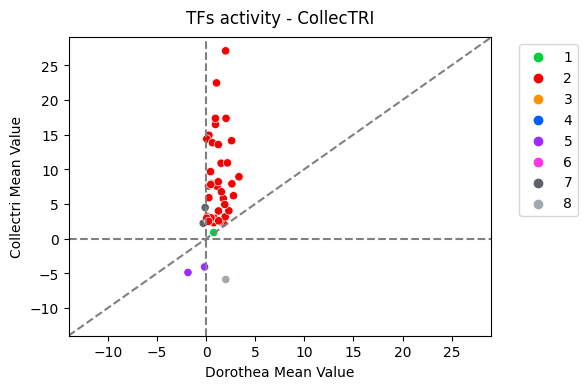

In [ ]:
plot_tf_scatterplot(df_collectri, "CollecTRI", show_text=False)

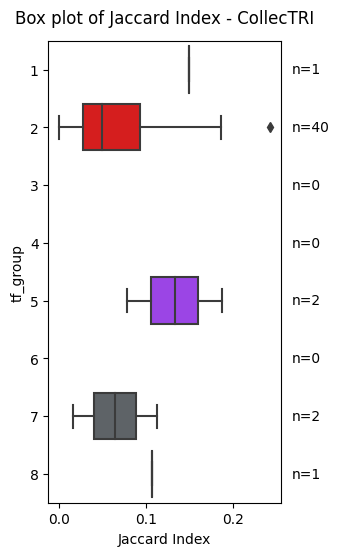

In [ ]:
plot_jaccard_boxplot(df_collectri, "CollecTRI")

Group 1 - Wilcoxon Test P-value: 1.0000
Group 2 - Wilcoxon Test P-value: 0.0047
Group 5 - Wilcoxon Test P-value: 1.0000
Group 7 - Wilcoxon Test P-value: 0.5000
Group 8 - Wilcoxon Test P-value: 1.0000


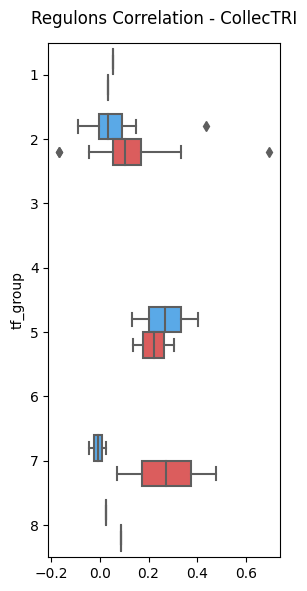

In [ ]:
plot_horizontal_boxplot(df_collectri, "CollecTRI")

Group 1 - Wilcoxon Test P-value: 1.0000
Group 2 - Wilcoxon Test P-value: 0.0000
Group 5 - Wilcoxon Test P-value: 0.5000
Group 7 - Wilcoxon Test P-value: 0.5000
Group 8 - Wilcoxon Test P-value: 1.0000


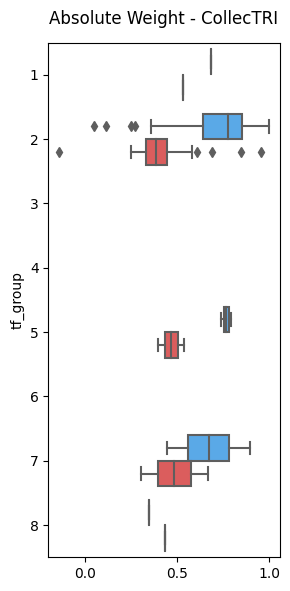

In [ ]:
plot_horizontal_boxplot(df_collectri, "CollecTRI", prefix="weight")

#### 2. DoRothEA alone

In [ ]:
df_dorothea = calculate_correlation_regulons(list(acts_dorothea), "dorothea")
df_dorothea.head()

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,weight_collectri,weight_dorothea,Jaccard Index,Jaccard Weight,Jaccard Collectri,Jaccard Dorothea,marker,tf_group,significant_group
11,MYC,1.929774,4.190561,0.074771,0.134906,0.810811,0.798566,0.402073,0.984536,0.789414,0.864516,o,3,2
12,NFKB1,0.286096,-11.897500,0.110531,0.173820,0.833718,0.695333,0.336595,0.988372,0.568129,0.684000,^,7,2
19,WT1,2.468180,3.643310,0.018797,-0.040092,0.541401,0.032258,0.197452,0.935484,0.643312,0.645161,o,3,2
18,TP53,4.234194,7.481593,0.102666,0.104310,0.646341,0.490229,0.188722,0.936255,0.769309,0.819095,o,3,2
0,ATF6,1.893479,3.333752,-0.013667,-0.093634,0.724138,1.000000,0.172414,1.000000,0.724138,1.000000,o,3,2


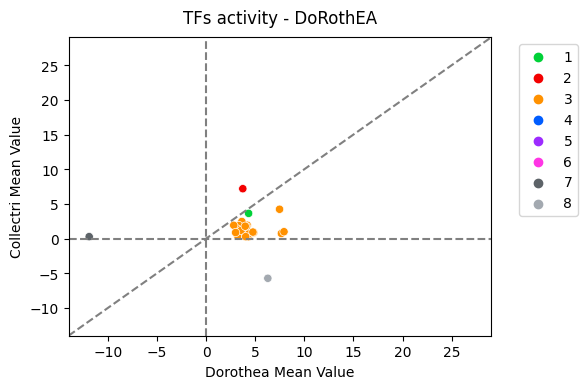

In [ ]:
plot_tf_scatterplot(df_dorothea, "DoRothEA", show_text=False)

Paired group 3 and 7 is significant with p-value: 0.0292


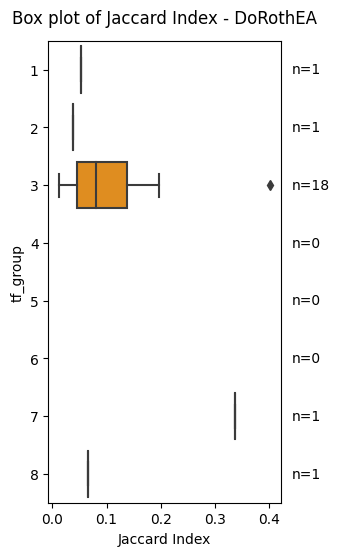

In [ ]:
plot_jaccard_boxplot(df_dorothea, "DoRothEA")

Group 1 - Wilcoxon Test P-value: 1.0000
Group 2 - Wilcoxon Test P-value: 1.0000
Group 3 - Wilcoxon Test P-value: 0.2121
Group 7 - Wilcoxon Test P-value: 1.0000
Group 8 - Wilcoxon Test P-value: 1.0000


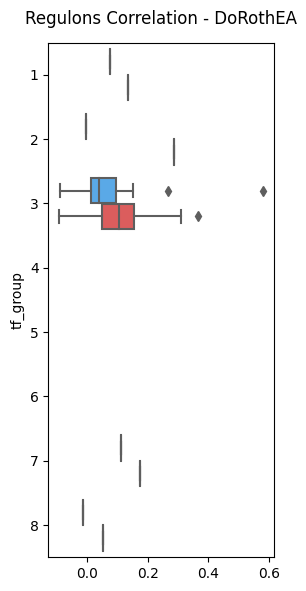

In [ ]:
plot_horizontal_boxplot(df_dorothea, "DoRothEA")

Group 1 - Wilcoxon Test P-value: 1.0000
Group 2 - Wilcoxon Test P-value: 1.0000
Group 3 - Wilcoxon Test P-value: 0.0001
Group 7 - Wilcoxon Test P-value: 1.0000
Group 8 - Wilcoxon Test P-value: 1.0000


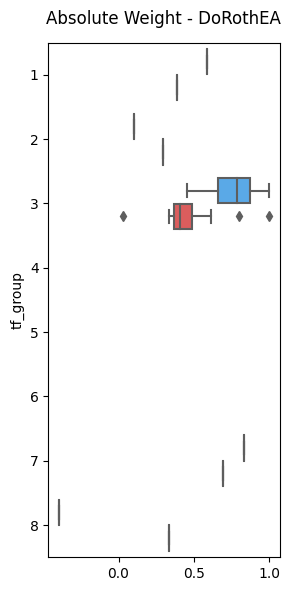

In [ ]:
plot_horizontal_boxplot(df_dorothea, "DoRothEA", prefix="weight")

#### 3. Both CollecTRI and DoRothEA

In [ ]:
df_both = calculate_correlation_regulons(list(acts_both), "both")
df_both.head()

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,weight_collectri,weight_dorothea,Jaccard Index,Jaccard Weight,Jaccard Collectri,Jaccard Dorothea,marker,tf_group,significant_group
18,RELA,3.242743,-12.932334,0.087019,0.065716,0.779359,0.610425,0.265723,0.952663,0.592527,0.736626,^,7,3
23,SP1,10.333795,8.190713,0.090725,0.052092,0.929641,0.809645,0.245500,0.979472,0.645210,0.705584,o,2,3
31,USF1,6.551861,4.326942,0.130901,0.162630,0.876652,0.651090,0.237037,0.968750,0.559471,0.691589,o,2,3
32,USF2,3.730333,5.293927,0.072704,0.265408,0.878261,0.540230,0.215789,1.000000,0.547826,0.810345,o,3,3
10,HIF1A,10.270652,5.752247,0.030776,0.016285,0.887689,0.729008,0.214405,0.976562,0.701944,0.816794,o,2,3


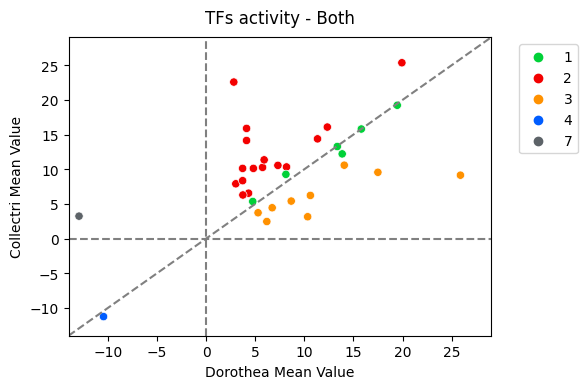

In [ ]:
plot_tf_scatterplot(df_both, "Both", show_text=False)

Paired group 1 and 7 is significant with p-value: 0.0322
Paired group 3 and 7 is significant with p-value: 0.0413


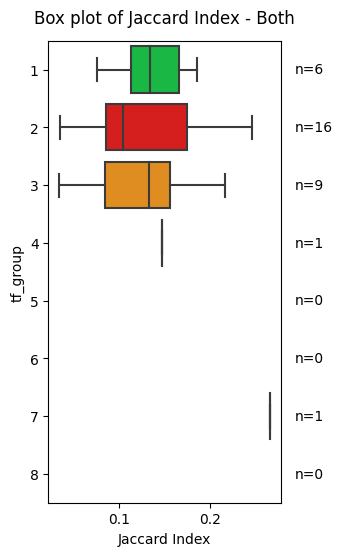

In [ ]:
plot_jaccard_boxplot(df_both, "Both")

Group 1 - Wilcoxon Test P-value: 0.4375
Group 2 - Wilcoxon Test P-value: 0.2312
Group 3 - Wilcoxon Test P-value: 0.5703
Group 4 - Wilcoxon Test P-value: 1.0000
Group 7 - Wilcoxon Test P-value: 1.0000


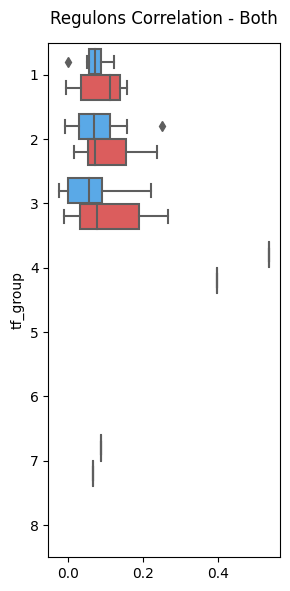

In [ ]:
plot_horizontal_boxplot(df_both, "Both")

Group 1 - Wilcoxon Test P-value: 0.0625
Group 2 - Wilcoxon Test P-value: 0.0001
Group 3 - Wilcoxon Test P-value: 0.0039
Group 4 - Wilcoxon Test P-value: 1.0000
Group 7 - Wilcoxon Test P-value: 1.0000


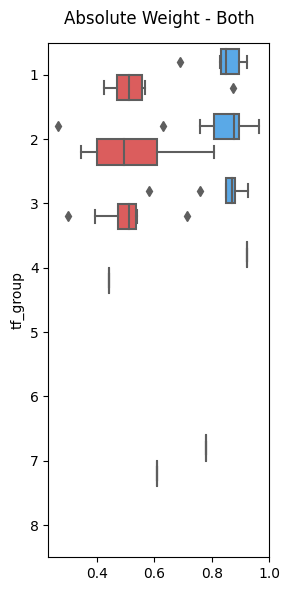

In [ ]:
plot_horizontal_boxplot(df_both, "Both", prefix="weight")

#### 4. Non-significant

In [ ]:
df_none = calculate_correlation_regulons(list(acts_none), "none")
df_none.head()

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,weight_collectri,weight_dorothea,Jaccard Index,Jaccard Weight,Jaccard Collectri,Jaccard Dorothea,marker,tf_group,significant_group
125,STAT4,-0.066540,0.116216,0.203497,0.060989,0.875000,0.653846,0.285714,1.000000,0.375000,0.692308,v,8,4
20,E2F2,-0.828310,-0.178413,0.010644,0.036212,0.760000,0.765152,0.241379,1.000000,0.880000,0.954545,s,5,4
34,ETS2,1.568436,-0.281784,0.172205,0.177570,0.929825,0.983871,0.239316,0.964286,0.578947,0.612903,^,7,4
21,E2F3,0.949929,0.329109,0.011571,-0.000467,0.941176,0.952381,0.205882,1.000000,0.882353,0.857143,o,2,4
19,E2F1,0.668307,2.202244,0.024950,0.078238,0.791139,0.647808,0.196491,0.994048,0.832278,0.857143,o,3,4


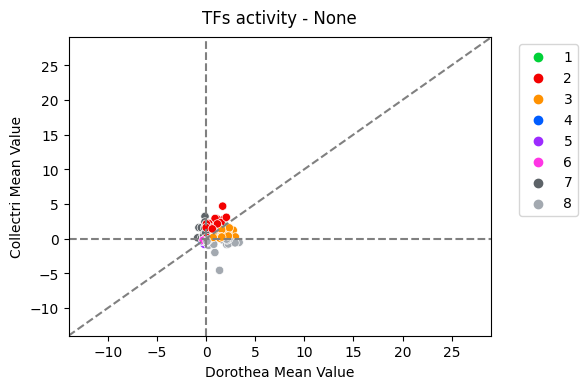

In [ ]:
plot_tf_scatterplot(df_none, "None", show_text=False)

Paired group 1 and 6 is significant with p-value: 0.0278
Paired group 2 and 4 is significant with p-value: 0.0291
Paired group 2 and 5 is significant with p-value: 0.0498
Paired group 3 and 4 is significant with p-value: 0.0481
Paired group 4 and 6 is significant with p-value: 0.0018


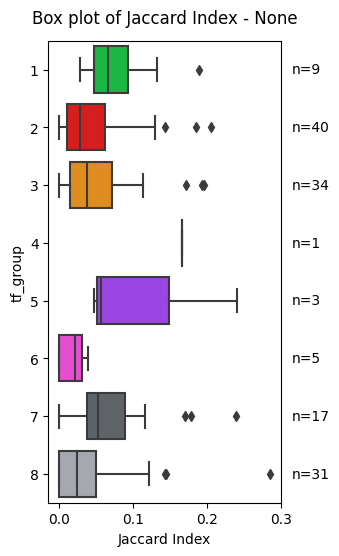

In [ ]:
plot_jaccard_boxplot(df_none, "None")

Group 1 - Wilcoxon Test P-value: 0.0742
Group 2 - Wilcoxon Test P-value: 0.0009
Group 3 - Wilcoxon Test P-value: 0.0015
Group 4 - Wilcoxon Test P-value: 1.0000
Group 5 - Wilcoxon Test P-value: 0.5000
Group 6 - Wilcoxon Test P-value: 0.6250
Group 7 - Wilcoxon Test P-value: 0.0267
Group 8 - Wilcoxon Test P-value: 0.0209


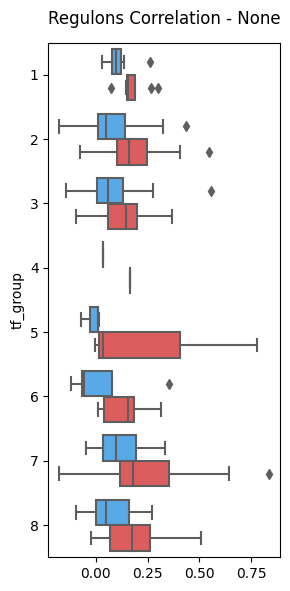

In [ ]:
plot_horizontal_boxplot(df_none, "None")

Group 1 - Wilcoxon Test P-value: 0.0039
Group 2 - Wilcoxon Test P-value: 0.0000
Group 3 - Wilcoxon Test P-value: 0.0000
Group 4 - Wilcoxon Test P-value: 1.0000
Group 5 - Wilcoxon Test P-value: 0.5000
Group 6 - Wilcoxon Test P-value: 0.0625
Group 7 - Wilcoxon Test P-value: 0.0001
Group 8 - Wilcoxon Test P-value: 0.0140


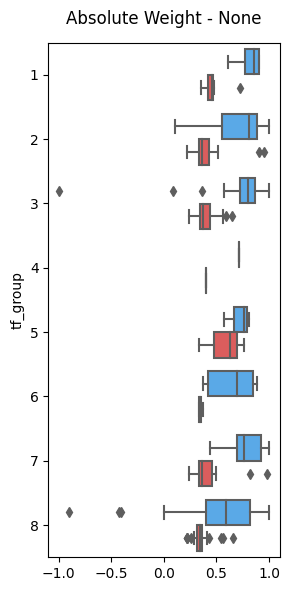

In [ ]:
plot_horizontal_boxplot(df_none, "None", prefix="weight")

#### 5. Full Overlap List

In [ ]:
df_all = calculate_correlation_regulons(list(overlap_tfs), "all")
df_all.head()

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,weight_collectri,weight_dorothea,Jaccard Index,Jaccard Weight,Jaccard Collectri,Jaccard Dorothea,marker,tf_group,significant_group
126,MYC,1.929774,4.190561,0.074771,0.134906,0.810811,0.798566,0.402073,0.984536,0.789414,0.864516,o,3,2
139,NFKB1,0.286096,-11.897500,0.110531,0.173820,0.833718,0.695333,0.336595,0.988372,0.568129,0.684000,^,7,2
203,STAT4,-0.066540,0.116216,0.203497,0.060989,0.875000,0.653846,0.285714,1.000000,0.375000,0.692308,v,8,4
171,RELA,3.242743,-12.932334,0.087019,0.065716,0.779359,0.610425,0.265723,0.952663,0.592527,0.736626,^,7,3
191,SP1,10.333795,8.190713,0.090725,0.052092,0.929641,0.809645,0.245500,0.979472,0.645210,0.705584,o,2,3


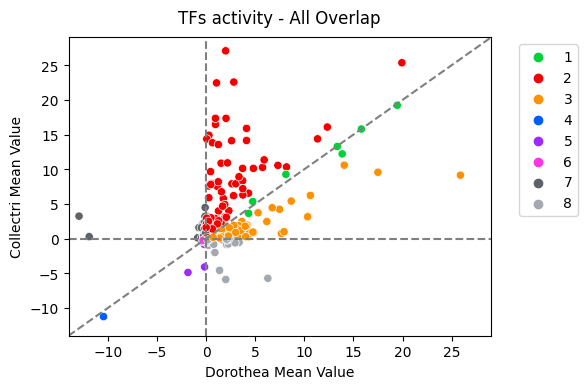

In [ ]:
plot_tf_scatterplot(df_all, "All Overlap", show_text=False)

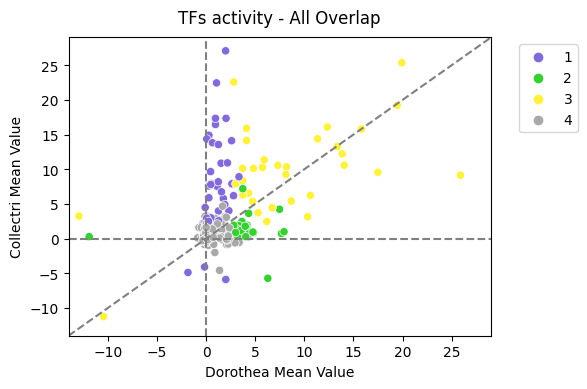

In [ ]:
plot_tf_scatterplot(df_all, "All Overlap", show_text=False, color_by="significant_group")

Paired group 1 and 2 is significant with p-value: 0.0363
Paired group 1 and 6 is significant with p-value: 0.0030
Paired group 1 and 8 is significant with p-value: 0.0018
Paired group 2 and 4 is significant with p-value: 0.0486
Paired group 3 and 8 is significant with p-value: 0.0313
Paired group 4 and 6 is significant with p-value: 0.0002
Paired group 4 and 8 is significant with p-value: 0.0135
Paired group 5 and 6 is significant with p-value: 0.0312
Paired group 5 and 8 is significant with p-value: 0.0154
Paired group 7 and 8 is significant with p-value: 0.0191


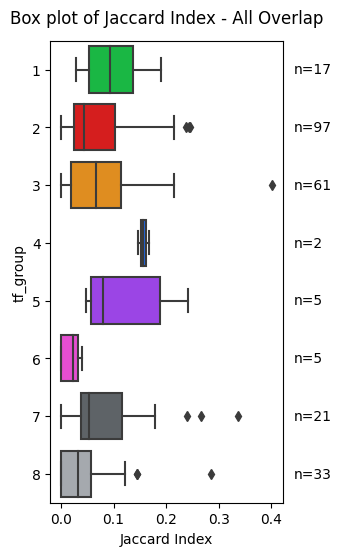

In [ ]:
plot_jaccard_boxplot(df_all, "All Overlap")

Group 1 - Wilcoxon Test P-value: 0.0348
Group 2 - Wilcoxon Test P-value: 0.0000
Group 3 - Wilcoxon Test P-value: 0.0006
Group 4 - Wilcoxon Test P-value: 1.0000
Group 5 - Wilcoxon Test P-value: 0.8125
Group 6 - Wilcoxon Test P-value: 0.6250
Group 7 - Wilcoxon Test P-value: 0.0101
Group 8 - Wilcoxon Test P-value: 0.0144


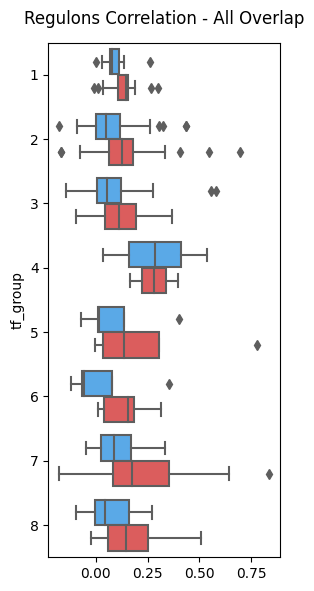

In [ ]:
plot_horizontal_boxplot(df_all, "All Overlap")

Group 1 - Wilcoxon Test P-value: 0.0000
Group 2 - Wilcoxon Test P-value: 0.0000
Group 3 - Wilcoxon Test P-value: 0.0000
Group 4 - Wilcoxon Test P-value: 0.5000
Group 5 - Wilcoxon Test P-value: 0.1250
Group 6 - Wilcoxon Test P-value: 0.0625
Group 7 - Wilcoxon Test P-value: 0.0000
Group 8 - Wilcoxon Test P-value: 0.0443


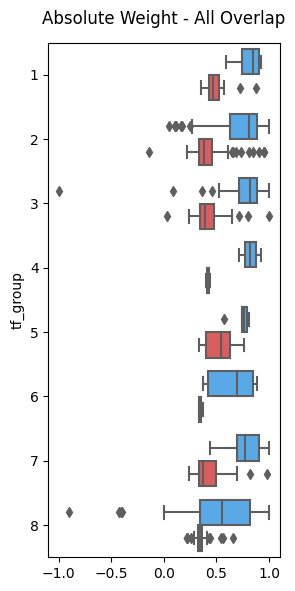

In [ ]:
plot_horizontal_boxplot(df_all, "All Overlap", prefix="weight")